### Initializing the predictive and generative (vae) models

In [1]:
### This script generates a molecule using the trained VAE model and 
# predicts the property of the generated molecule using the trained GNN model

import numpy as np
import pandas as pd
import selfies as sf
from src.pretrainedmodel import GNNmodel
from rdkit import Chem
import torch
import sys
sys.path.append('../')
from src.vae_module import VAE
from src.vae_module import flatten


graph_model_path = 'models'
prediction_model = GNNmodel(path = graph_model_path)

# load the trained VAE model
latent_dim = 32  # latent dimension of the VAE
vae = VAE(input_dim=3624, latent_dim=latent_dim)
vae.load_state_dict(torch.load('models/vae_model.pt'))

original_data = pd.read_csv('data/test_more_dataNoinionc.csv', header=None, names=['smiles', 'logCMC'])
original_data_input_smiles_list = original_data.iloc[:, 0].tolist()
# convert smiles to canonical smiles
original_data_input_smiles_list = [Chem.MolToSmiles(Chem.MolFromSmiles(sm), canonical=True) for sm in original_data_input_smiles_list]

def encode_data_from_smiles_to_vae_encoded(input_smiles_list):
    input_selfies_list = list(map(sf.encoder, input_smiles_list))
    # Parameters for encoding
    max_len = max(sf.len_selfies(s) for s in input_selfies_list)
    alphabet = sf.get_alphabet_from_selfies(input_selfies_list)
    alphabet.add("[nop]")
    alphabet = list(sorted(alphabet))
    vocab_stoi = {symbol: idx for idx, symbol in enumerate(alphabet)}
    vocab_itos = {idx: symbol for symbol, idx in vocab_stoi.items()}
    # Convert SELFIES to one-hot encoding
    input_one_hot_arr = np.array([sf.selfies_to_encoding(s, vocab_stoi, pad_to_len=max_len)[1] for s in input_selfies_list])
    ## Convert the "input_one_hot_arr" dataset to tensor
    input_one_hot_arr_tensor = torch.tensor(input_one_hot_arr, dtype=torch.float32)
    # Flatten the input data using the custom 'flatten' function
    # This function takes a 3D tensor 'x_train' and reshapes it into a 2D tensor
    width, height, input_dim, flattened_dataset = flatten(input_one_hot_arr_tensor)
    return height, vocab_itos, width

def generate_vae_molecules(n, height, vocab_itos, width):
    # Generate molecules from the trained VAE
    vae.eval()
    with torch.no_grad():
        latent_samples = torch.randn(n, latent_dim)
        generated_molecules = vae.decoder(latent_samples)
        # Convert the generated molecules to SMILES
        def generated_molecules_to_smiles(generated_molecules):
            # Reshape satisfying_molecules_tensor back to a 3D tensor
            generated_molecules_tensor_3d = generated_molecules.view(-1, width, height)
            # Convert the PyTorch 3D tensor to a NumPy array
            generated_molecules_numpy = generated_molecules_tensor_3d.numpy()
            max_values = np.max(generated_molecules_numpy, axis=2, keepdims=True)
            generated_data = np.where(generated_molecules_numpy == max_values, 1, 0)
            ### Reproduce SMILES list and visualize the output images
            output_smiles_list = []
            for i in range (0,len(generated_data)):
                sm = sf.decoder(sf.encoding_to_selfies(generated_data[i].tolist(), vocab_itos, enc_type="one_hot"))
                output_smiles_list.append(sm)
            return output_smiles_list
        # Convert the generated molecules to SMILES
        generated_molecules_smiles_list = generated_molecules_to_smiles(generated_molecules)
        # convert smiles to canonical smiles
        generated_molecules_smiles_list = [Chem.MolToSmiles(Chem.MolFromSmiles(sm), canonical=True) for sm in generated_molecules_smiles_list]
        # remove duplicates
        generated_molecules_smiles_list = list(set(generated_molecules_smiles_list))
        return generated_molecules_smiles_list
    
height, vocab_itos, width = encode_data_from_smiles_to_vae_encoded(original_data_input_smiles_list)

mol = generate_vae_molecules(1, height, vocab_itos, width)
print(f'generated molecule: {mol[0]}')

prop = prediction_model.predict(mol)
print(f'predicted property: {prop[0]}')

generated molecule: CCCCCCSCC=O
predicted property: 1.3475134372711182


In [2]:
# Function to generate molecules from a latent vector using the VAE model (Extracted from cell 1)
def generate_molecules_from_latent(latent_vector, height, vocab_itos, width):
    with torch.no_grad():  # Disable gradient calculation for efficiency
        generated_molecules = vae.decoder(latent_vector)  # Decode the latent vector
        # Reshape the decoded output to a 3D tensor
        generated_molecules_tensor_3d = generated_molecules.view(-1, width, height)
        generated_molecules_numpy = generated_molecules_tensor_3d.numpy()
        # Convert the output to a one-hot encoded format
        max_values = np.max(generated_molecules_numpy, axis=2, keepdims=True)
        generated_data = np.where(generated_molecules_numpy == max_values, 1, 0)
        # Convert the one-hot encoded molecules back to SMILES strings
        output_smiles_list = []
        for data in generated_data:
            sm = sf.decoder(sf.encoding_to_selfies(data.tolist(), vocab_itos, enc_type="one_hot"))
            output_smiles_list.append(sm)
        # # Canonicalize the SMILES and remove duplicates
        # output_smiles_list = [Chem.MolToSmiles(Chem.MolFromSmiles(sm), canonical=True) for sm in output_smiles_list if Chem.MolFromSmiles(sm)]
        # output_smiles_list = list(set(output_smiles_list))  # Remove duplicates
        return output_smiles_list

### RL Using Stable-Baseline3 and OpenAI Gymnesium (Custom) Environment for Optimizing the Latent Space Sampling

In [4]:
import gymnasium as gym  # Import Gymnasium (successor of OpenAI Gym)
from stable_baselines3 import PPO  # Import the PPO algorithm from Stable Baselines3
from stable_baselines3.common.vec_env import DummyVecEnv  # Correct import for DummyVecEnv
import matplotlib.pyplot as plt
from stable_baselines3 import SAC

In [ ]:
# Initialize lists to store rewards
rewards = []
max_step = 100  # Set the maximum number of steps per episode
step_count_per_episode = []  # Initialize a list to store the step count per episode

# Define a custom Gymnasium environment for your molecular generation task
class MoleculeEnv(gym.Env):
    def __init__(self, vae, prediction_model, latent_dim, height, vocab_itos, width, max_step=max_step):
        super(MoleculeEnv, self).__init__()

        # Initialize the VAE model and prediction model
        self.vae = vae
        self.prediction_model = prediction_model
        # Parameters related to the VAE and the latent space
        self.latent_dim = latent_dim
        self.height = height
        self.vocab_itos = vocab_itos
        self.width = width
        self.max_step = max_step  # Set the maximum number of steps per episode
        # Action space: continuous values between -5 and 5 to match the latent space
        self.action_space = gym.spaces.Box(low=-5.0, high=5.0, shape=(latent_dim,), dtype=np.float32)
        # Observation space
        self.observation_space = gym.spaces.Box(low=-5.0, high=5.0, shape=(latent_dim,), dtype=np.float32)
        # Initialize the latent vector (state) randomly
        self.state = torch.randn(1, self.latent_dim)

    def reset(self, seed=None):
        # Reset the environment by sampling a new random latent vector
        self.state = torch.randn(1, self.latent_dim)
        self.current_step = 0  # Reset step counter
        return self.state.numpy().flatten(), {}  # Return the state as a flattened NumPy array and an info dictionary

    def step(self, action):
        self.state = torch.tensor(action, dtype=torch.float32)
        # Decode the latent state using the VAE to generate a molecule
        generated_smiles_list = generate_molecules_from_latent(self.state, self.height, self.vocab_itos, self.width)
        # Calculate the reward based on the predicted property value
        if generated_smiles_list:
            property_value = self.prediction_model.predict(generated_smiles_list)[0]
            reward = reward_function(property_value)  # Calculate the reward using the custom reward function
            done = property_value < -1 # End the episode if the desired property condition is met
            if done:
                self.desired_state = self.state.clone()  # Store the state if the condition is met
        else:
            reward = -100  # Penalize if no valid molecule is generated
            done = False  # Episode 
        self.current_step += 1  # Increment the step counter   
        # End the episode if the maximum number of steps is reached
        if self.current_step >= self.max_step:
            done = True
        step_count_per_episode.append(self.current_step)  # Append the step count to the list
        rewards.append(reward)  # Append the reward to the rewards list

        # Include property_value in info if available, for easier access during evaluation
        info = {"property_value": float(property_value)} if generated_smiles_list else {}
        
        # return self.state.numpy().flatten(), reward, done, False, {}
        return self.state.numpy().flatten(), reward, done, False, info
    
# Reward function to incentivize the agent to generate molecules with properties less than -1
def reward_function(property_value):
    if property_value <= -1:
        return   -10*(property_value + 1 ) # High reward for achieving the desired property
    else:
        return   -100*(property_value + 1)  # Penalize based on the distance from the desired threshold

# Create and vectorize the custom Gym environment
env = MoleculeEnv(vae, prediction_model, latent_dim, height, vocab_itos, width, max_step=max_step)
env = DummyVecEnv([lambda: env])  # Vectorize the environment for parallelization

# Initialize the SAC model with default parameters
model = SAC("MlpPolicy",env,verbose=1)

# Open a file to write the output
with open("training_sac_1.txt", "w") as f:
    # Redirect stdout to the file
    sys.stdout = f
    # Train the PPO model
    model.learn(total_timesteps=200000)
    # Reset stdout to default
    sys.stdout = sys.__stdout__
# Save the trained model to a file for later use
model.save("sac_1_molecule_model")

Using cpu device


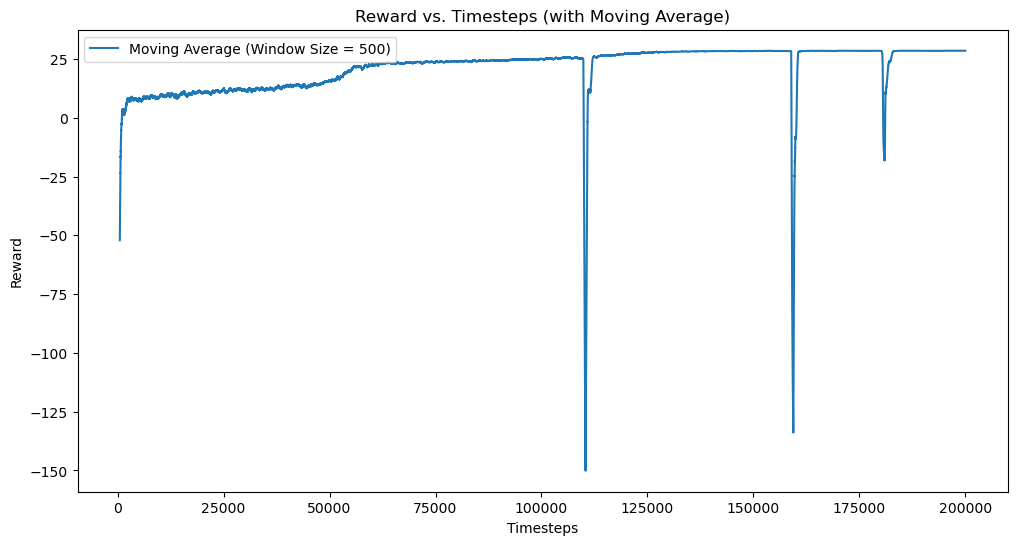

In [5]:
window_size = 500 # Adjust this based on how much smoothing you want
def moving_average(data, window_size=window_size):
    """Calculate the moving average of the data with the specified window size."""
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')
smoothed_rewards = moving_average(rewards, window_size)

plt.figure(figsize=(12, 6))
# Plot the moving average of rewards
plt.plot(range(window_size - 1, len(rewards)), smoothed_rewards, label=f"Moving Average (Window Size = {window_size})")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Reward vs. Timesteps (with Moving Average)")
plt.legend()
plt.savefig("reward_vs_timesteps_plot_sac_1.png", dpi=300)
plt.show()


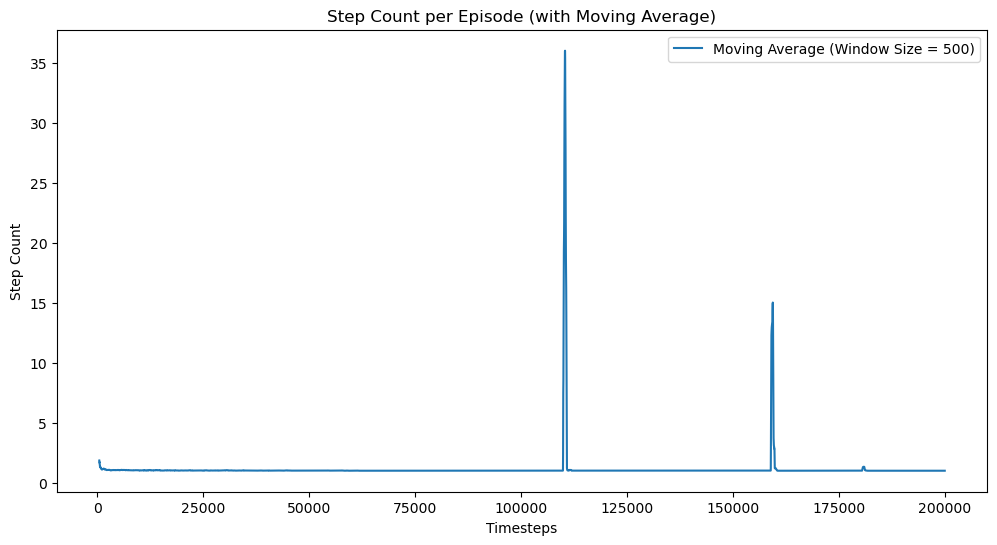

In [6]:
# smooth the step count per episode using a moving average
smoothed_step_count = moving_average(step_count_per_episode, window_size)
# plot the smoothed step count per episode
plt.figure(figsize=(12, 6))
plt.plot(range(window_size - 1, len(step_count_per_episode)), smoothed_step_count, label=f"Moving Average (Window Size = {window_size})")
plt.xlabel("Timesteps")
plt.ylabel("Step Count")
plt.title("Step Count per Episode (with Moving Average)")
plt.legend()
plt.savefig("step_count_vs_timesteps_plot_sac_1.png", dpi=300)
plt.show()


In [6]:
model = SAC.load("sac_1_molecule_model")

In [7]:
def RL_agent(n, steps=1):
    generated_smiles_list = []
    for _ in range(n):
        # Reset the environment
        state = env.reset()
        for step in range(steps):
            action, _states = model.predict(state, deterministic=True)            
            state, reward, done, info = env.step(action)         
            if done[0]:  # Check the `done` flag in a vectorized environment
                break
        desired_state = env.get_attr("desired_state")[0]  # Access the stored state with the desired property
        latent_vector = torch.tensor(desired_state).squeeze(0)  # Remove the batch dimension from the state
        generated_smile = generate_molecules_from_latent(latent_vector, env.envs[0].height, env.envs[0].vocab_itos, env.envs[0].width)
        generated_smiles_list += generated_smile
    return generated_smiles_list

In [8]:
generated_smile = RL_agent(100)
duplicate_smiles = []
unique_smiles = []
for sm in generated_smile:
    if sm not in unique_smiles:
        unique_smiles.append(sm)
    else:
        duplicate_smiles.append(sm)
len(generated_smile), len(unique_smiles), len(duplicate_smiles)

C:\Users\okafo\AppData\Local\Temp\ipykernel_18436\1395623527.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_vector = torch.tensor(desired_state).squeeze(0)  # Remove the batch dimension from the state


(100, 1, 99)

In [9]:
prop = prediction_model.predict(generated_smile)
len([p for p in prop if p < -1])

100

In [10]:
prop

[-3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.8502994775772095,
 -3.850299

In [20]:
generated_smile

['OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCCCCCCCCCCCCSCCCCCF',
 'OCCOCCCC